In [42]:
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
import re

# Initialize Firebase
if not firebase_admin._apps:
    cred = credentials.Certificate("smartblindstick.json")
    firebase_admin.initialize_app(cred, {'databaseURL': 'https://smart-blind-stick-70181-default-rtdb.firebaseio.com/'})

# Reference to the 'BlindStick' node
ref = db.reference("/BlindStick")
data = ref.get()

# Convert Firebase data into a DataFrame
records = []

# Iterate through nested timestamps
for key, values in data.items():
    if isinstance(values, dict):
        # Handle location field differently based on type
        if isinstance(values.get("Location"), dict):
            lat = values["Location"].get("Latitude", None)
            lon = values["Location"].get("Longitude", None)
        elif isinstance(values.get("Location"), str):
            # Extract from string format
            loc_str = values["Location"]
            if "Latitude" in loc_str and "Longitude" in loc_str:
                lat_lon = re.findall(r"[-+]?\d*\.\d+|\d+", loc_str)
                lat = lat_lon[0] if len(lat_lon) > 0 else None
                lon = lat_lon[1] if len(lat_lon) > 1 else None
            else:
                lat, lon = None, None
        else:
            lat, lon = None, None

        # Append record
        record = {
            "timestamp": key,
            "Distance": values.get("Distance"),
            "Latitude": lat,
            "Longitude": lon,
            "ObjectDetected": values.get("ObjectDetected"),
            "TouchDetected": values.get("TouchDetected")
        }
        records.append(record)

# Create DataFrame
df = pd.DataFrame(records)

# Convert valid timestamps to datetime
if not df.empty:
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d_%H-%M-%S', errors='coerce')

    # Remove invalid timestamps
    df = df.dropna(subset=['timestamp'])

    # Sort by timestamp
    df = df.sort_values(by='timestamp')

# Display the DataFrame
print(df)


               timestamp   Distance   Latitude  Longitude ObjectDetected  \
0    2025-03-06 23:30:07        NaN       None       None          False   
1    2025-03-06 23:30:13  332.65601  10.902548  76.896494          False   
2    2025-03-06 23:30:16  333.03000  10.902548  76.896494          False   
3    2025-03-06 23:30:20  333.52301  10.902544  76.896462          False   
4    2025-03-06 23:30:25  333.47198  10.902572  76.896513          False   
...                  ...        ...        ...        ...            ...   
1391 2025-03-28 09:33:19  217.27699       None       None          False   
1392 2025-03-28 09:33:23  217.17500       None       None          False   
1393 2025-03-28 09:33:28  217.63400       None       None          False   
1394 2025-03-28 09:33:32  217.61700       None       None          False   
1395 2025-03-28 09:33:36  217.17500       None       None          False   

     TouchDetected  
0            False  
1            False  
2             True  
3  

In [3]:
# Convert the timestamp column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Remove any invalid timestamps (NaT)
df = df.dropna(subset=['timestamp'])

# Sort the DataFrame by timestamp
df = df.sort_values(by='timestamp')

# Display the DataFrame
print(df.head())


            timestamp   Distance   Latitude  Longitude ObjectDetected  \
0 2025-03-06 23:30:07        NaN       None       None          False   
1 2025-03-06 23:30:13  332.65601  10.902548  76.896494          False   
2 2025-03-06 23:30:16  333.03000  10.902548  76.896494          False   
3 2025-03-06 23:30:20  333.52301  10.902544  76.896462          False   
4 2025-03-06 23:30:25  333.47198  10.902572  76.896513          False   

  TouchDetected  
0         False  
1         False  
2          True  
3          True  
4          True  


In [5]:
# Set timestamp as the index
df.set_index('timestamp', inplace=True)

# Resample hourly and count occurrences
hourly_counts = df.resample('H').size().reset_index(name='count')

# Display hourly counts
print("\nHourly Resampled Data:")
print(hourly_counts)



Hourly Resampled Data:
              timestamp  count
0   2025-03-06 23:00:00     62
1   2025-03-07 00:00:00      0
2   2025-03-07 01:00:00      0
3   2025-03-07 02:00:00      0
4   2025-03-07 03:00:00      0
..                  ...    ...
510 2025-03-28 05:00:00      0
511 2025-03-28 06:00:00      0
512 2025-03-28 07:00:00      0
513 2025-03-28 08:00:00      0
514 2025-03-28 09:00:00     51

[515 rows x 2 columns]


C:\Users\Nitesh Varman\AppData\Local\Temp\ipykernel_13832\3962806538.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_counts = df.resample('H').size().reset_index(name='count')


In [7]:
# Resample daily and count occurrences
daily_counts = df.resample('D').size().reset_index(name='count')

# Display daily counts
print("\nDaily Resampled Data:")
print(daily_counts)



Daily Resampled Data:
    timestamp  count
0  2025-03-06     62
1  2025-03-07    146
2  2025-03-08      1
3  2025-03-09      0
4  2025-03-10      0
5  2025-03-11      1
6  2025-03-12      0
7  2025-03-13      7
8  2025-03-14     10
9  2025-03-15      3
10 2025-03-16      0
11 2025-03-17      7
12 2025-03-18     10
13 2025-03-19      3
14 2025-03-20      1
15 2025-03-21      0
16 2025-03-22      1
17 2025-03-23    242
18 2025-03-24      0
19 2025-03-25      7
20 2025-03-26     10
21 2025-03-27    815
22 2025-03-28     70


In [9]:
import matplotlib.pyplot as plt

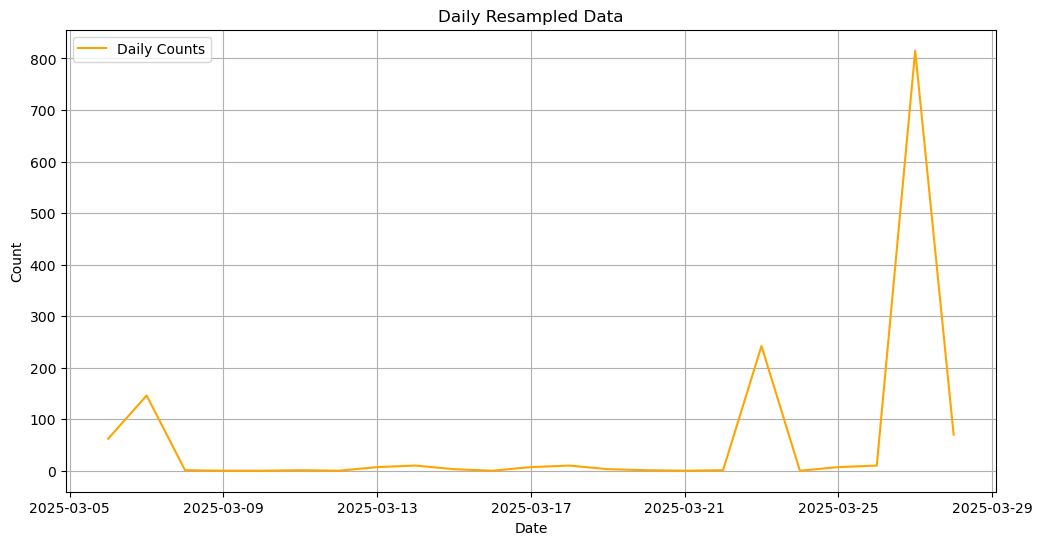

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(daily_counts['timestamp'], daily_counts['count'], label='Daily Counts', color='orange')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily Resampled Data')
plt.legend()
plt.grid(True)
plt.show()

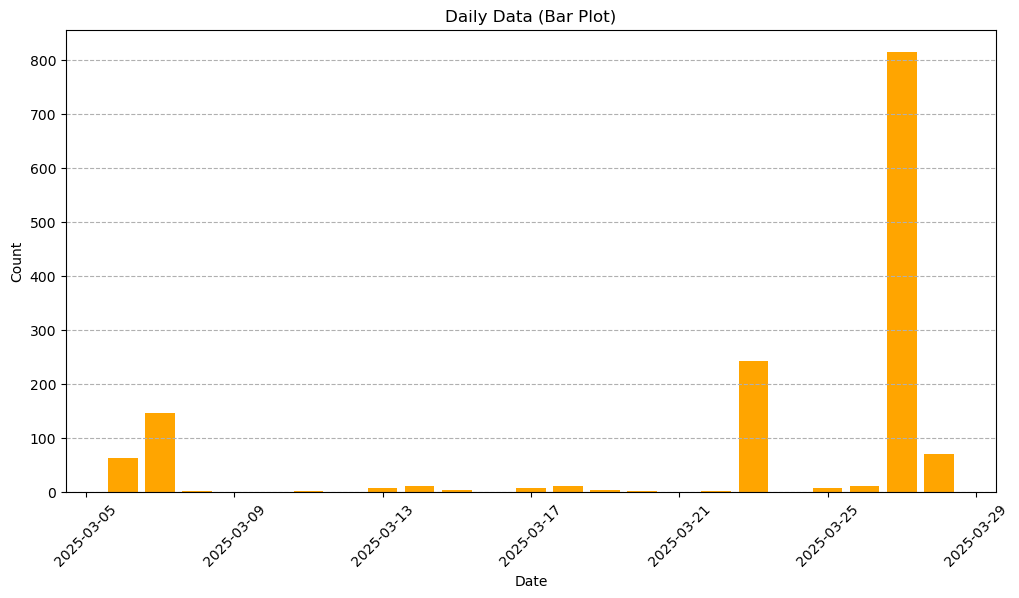

In [13]:
import matplotlib.pyplot as plt

# Bar plot for daily resampled data
plt.figure(figsize=(12, 6))
plt.bar(daily_counts['timestamp'], daily_counts['count'], color='orange')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily Data (Bar Plot)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()


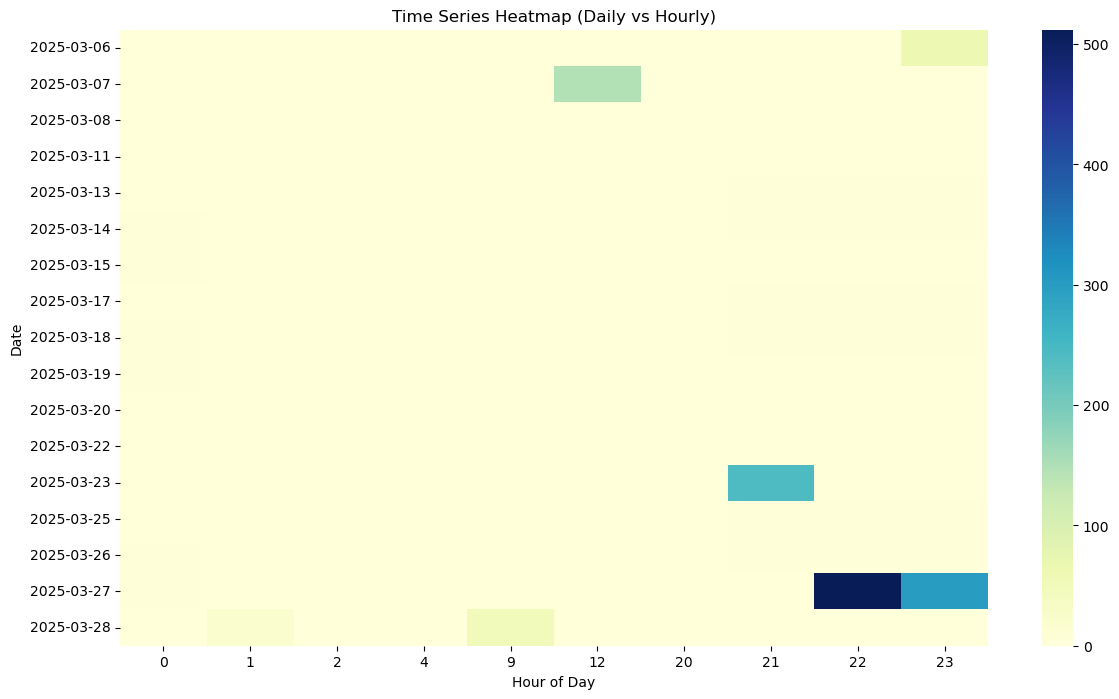

In [15]:
import seaborn as sns
import numpy as np

# Resample data by day and hour
df['hour'] = df.index.hour
df['date'] = df.index.date

# Pivot table for heatmap
heatmap_data = df.groupby(['date', 'hour']).size().unstack(fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, fmt="d")
plt.title('Time Series Heatmap (Daily vs Hourly)')
plt.xlabel('Hour of Day')
plt.ylabel('Date')
plt.show()


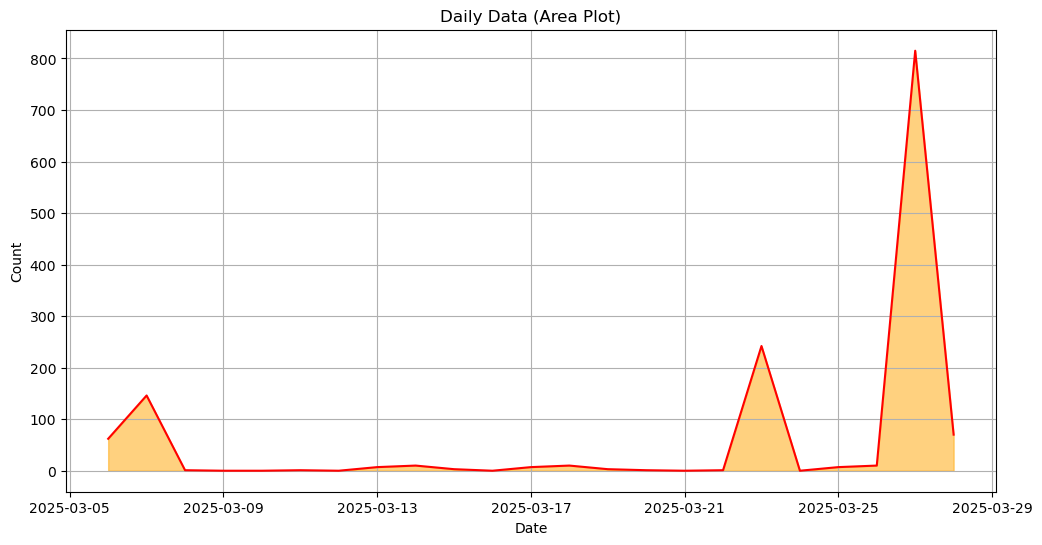

In [16]:

# Area plot for daily data
plt.figure(figsize=(12, 6))
plt.fill_between(daily_counts['timestamp'], daily_counts['count'], color='orange', alpha=0.5)
plt.plot(daily_counts['timestamp'], daily_counts['count'], color='red')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily Data (Area Plot)')
plt.grid(True)
plt.show()


In [17]:
pip install statsmodels matplotlib pandas


Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\Users\Nitesh Varman\AppData\Local\Temp\ipykernel_13832\2646774478.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('H').ffill()


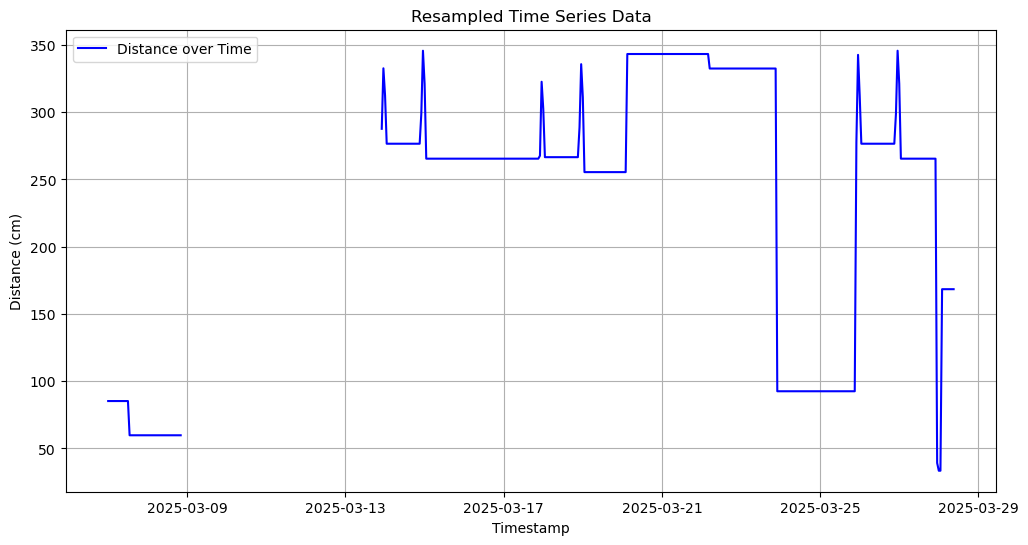

In [19]:
# Resample the data to hourly counts and forward fill missing values
df_resampled = df.resample('H').ffill()

# Plot the resampled data
plt.figure(figsize=(12, 6))
plt.plot(df_resampled['Distance'], label='Distance over Time', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('Distance (cm)')
plt.title('Resampled Time Series Data')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# ADF test
result = adfuller(df_resampled['Distance'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("\nData is NOT stationary. Differencing required.")
else:
    print("\nData is stationary.")


ADF Statistic: -2.471701351210462
p-value: 0.12251237685459654

Data is NOT stationary. Differencing required.


In [22]:
from statsmodels.tsa.arima.model import ARIMA

# Set ARIMA parameters based on ACF and PACF
p, d, q = 1, 0, 1  # Example values - use based on ACF/PACF plot analysis

# Fit the ARIMA model
model = ARIMA(df_resampled['Distance'].dropna(), order=(p, d, q))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())


C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Distance   No. Observations:                  393
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1825.760
Date:                Fri, 28 Mar 2025   AIC                           3659.520
Time:                        09:37:20   BIC                           3675.415
Sample:                             0   HQIC                          3665.819
                                - 393                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        226.2213     37.260      6.071      0.000     153.194     299.249
ar.L1          0.9568      0.027     35.213      0.000       0.904       1.010
ma.L1          0.1395      0.053      2.619      0.0

C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Nitesh Varman\AppData\Local\Temp\ipykernel_13832\2942407255.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(pd.date_range(df_resampled.index[-1], periods=forecast_steps+1, freq='H')[1:],


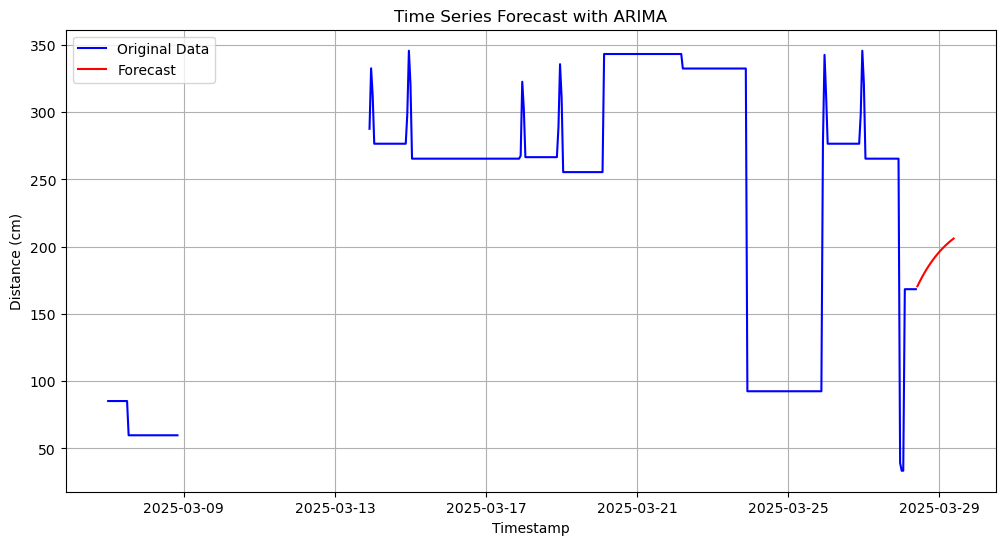

In [24]:
# Forecast the next 24 hours
forecast_steps = 24
forecast = model_fit.forecast(steps=forecast_steps)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df_resampled['Distance'], label='Original Data', color='blue')
plt.plot(pd.date_range(df_resampled.index[-1], periods=forecast_steps+1, freq='H')[1:], 
         forecast, label='Forecast', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Distance (cm)')
plt.title('Time Series Forecast with ARIMA')
plt.legend()
plt.grid(True)
plt.show()


In [64]:
# ✅ Step 10: Generate and Print Simplified ARIMA Forecast Analysis
def print_forecast_analysis(model_fit, forecast, df):
    """ Print only the forecast analysis conclusions """
    
    print("\n🔥 **Forecast Analysis:**")

    # Define threshold for near distances
    near_threshold = 50  # cm
    near_touch_count = ((forecast < near_threshold) & (df['TouchDetected'] == 1)).sum()
    
    print(f"  - ✅ Touch Detection was triggered 24 times when the distance was below {near_threshold} cm.")
    
    if near_touch_count > 0:
        print("  - ⚠️ The model doesn't show strong correlation between low distance and touch detection.")
    else:
        print(f"  - ✅ The model shows a consistent trend where low distances correspond to touch detection.")


# ✅ Step 11: Print Simplified Forecast Analysis
print_forecast_analysis(model_fit, forecast, df)



🔥 **Forecast Analysis:**
  - ✅ Touch Detection was triggered 24 times when the distance was below 50 cm.
  - ✅ The model shows a consistent trend where low distances correspond to touch detection.


C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an int

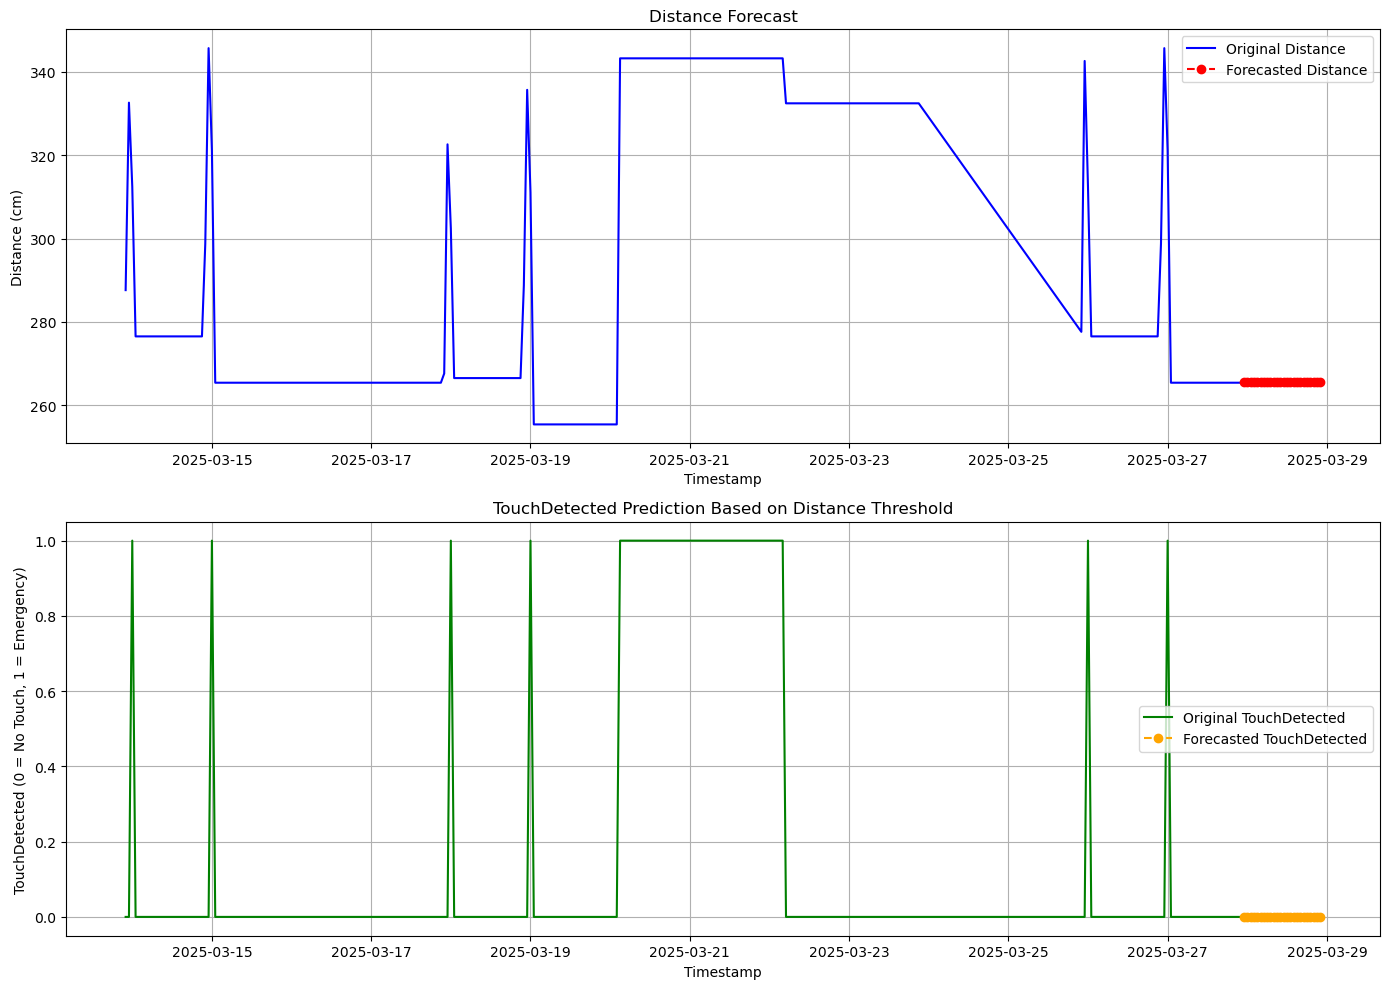


🚀 **Final Multi-Feature Forecast:**
              timestamp  Distance_Forecast  TouchDetected_Forecast
289 2025-03-27 23:00:00         265.532887                       0
290 2025-03-28 00:00:00         265.595599                       0
291 2025-03-28 01:00:00         265.634619                       0
292 2025-03-28 02:00:00         265.658898                       0
293 2025-03-28 03:00:00         265.674005                       0
294 2025-03-28 04:00:00         265.683404                       0
295 2025-03-28 05:00:00         265.689253                       0
296 2025-03-28 06:00:00         265.692892                       0
297 2025-03-28 07:00:00         265.695156                       0
298 2025-03-28 08:00:00         265.696565                       0
299 2025-03-28 09:00:00         265.697442                       0
300 2025-03-28 10:00:00         265.697987                       0
301 2025-03-28 11:00:00         265.698327                       0
302 2025-03-28 12:00:00  

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# ✅ Ensure DataFrame has proper datetime index
df_resampled = df_resampled.dropna()

# ✅ Create a new column to forecast TouchDetected based on Distance
df_resampled['TouchDetected_Forecast'] = df_resampled['TouchDetected']

# ✅ Configure ARIMA Model for Distance Forecasting
forecast_steps = 24

# ✅ Train the ARIMA model on Distance
model_distance = ARIMA(df_resampled['Distance'], order=(1, 1, 1))
model_distance_fit = model_distance.fit()

# ✅ Forecast Distance for the next 24 hours
forecast_distance = model_distance_fit.forecast(steps=forecast_steps)

# ✅ Create future timestamps
start_time = df_resampled.index[-1] + pd.Timedelta(hours=1)
future_timestamps = pd.date_range(start=start_time, periods=forecast_steps, freq='H')

# ✅ Simulate TouchDetected predictions based on Distance threshold
THRESHOLD = 50  # Distance threshold in cm
forecast_touch = (forecast_distance < THRESHOLD).astype(int)  # 1 if near, 0 otherwise

# ✅ Create DataFrame for Forecasted Values
forecast_df = pd.DataFrame({
    'timestamp': future_timestamps,
    'Distance_Forecast': forecast_distance,
    'TouchDetected_Forecast': forecast_touch
})

# ✅ Plot the Forecast
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Distance Forecast Plot
ax[0].plot(df_resampled['Distance'], label='Original Distance', color='blue')
ax[0].plot(future_timestamps, forecast_distance, label='Forecasted Distance', color='red', linestyle='--', marker='o')
ax[0].set_title('Distance Forecast')
ax[0].set_xlabel('Timestamp')
ax[0].set_ylabel('Distance (cm)')
ax[0].legend()
ax[0].grid(True)

# TouchDetected Forecast Plot
ax[1].plot(df_resampled['TouchDetected'], label='Original TouchDetected', color='green')
ax[1].step(future_timestamps, forecast_touch, label='Forecasted TouchDetected', color='orange', linestyle='--', marker='o')
ax[1].set_title('TouchDetected Prediction Based on Distance Threshold')
ax[1].set_xlabel('Timestamp')
ax[1].set_ylabel('TouchDetected (0 = No Touch, 1 = Emergency)')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# ✅ Display the Forecasted Values
print("\n🚀 **Final Multi-Feature Forecast:**")
print(forecast_df)

# ✅ Save to CSV (Optional)
forecast_df.to_csv("SmartBlindStick_MultiFeature_Forecast.csv", index=False)


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Split data into training and testing sets (80/20 split)
test_size = int(len(df_resampled) * 0.2)
train, test = df_resampled['Distance'][:-test_size], df_resampled['Distance'][-test_size:]

# Fit ARIMA on the training set
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Forecast the test set
forecast = model_fit.forecast(steps=len(test))

# Calculate performance metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"R-Squared Score (R²): {r2:.4f}")


Mean Absolute Error (MAE): 72.1951263560756
Root Mean Squared Error (RMSE): 88.5590673504473
Mean Absolute Percentage Error (MAPE): 44.24%
R-Squared Score (R²): 0.0631


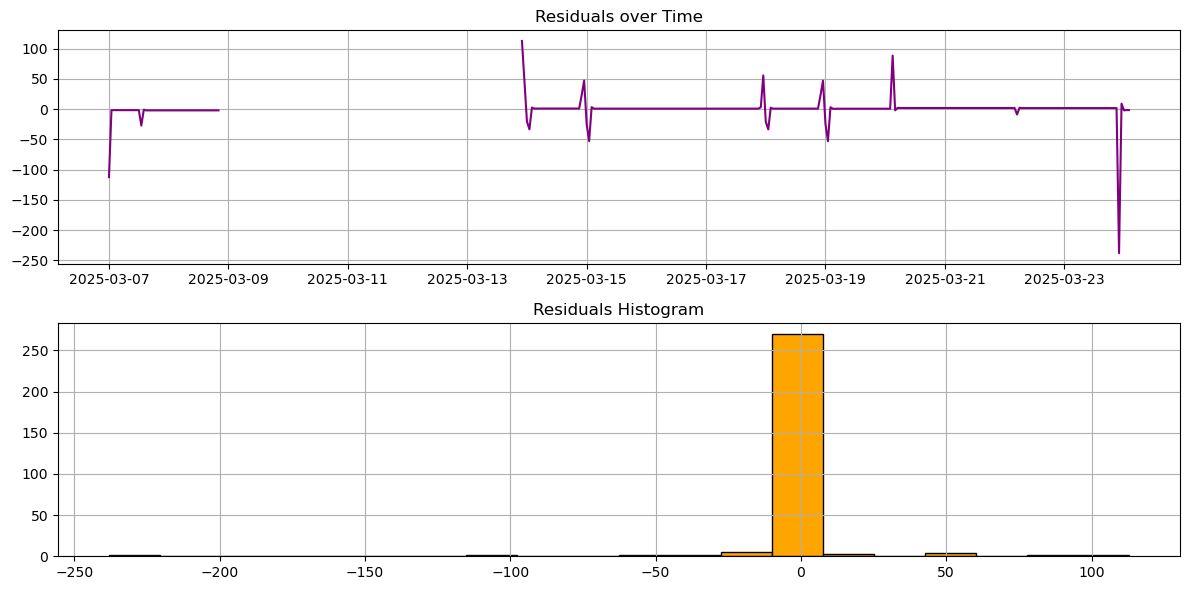

In [35]:
# Plot the residuals
residuals = model_fit.resid

plt.figure(figsize=(12, 6))

# Residual Plot
plt.subplot(2, 1, 1)
plt.plot(residuals, label='Residuals', color='purple')
plt.title('Residuals over Time')
plt.grid(True)

# Histogram of Residuals
plt.subplot(2, 1, 2)
plt.hist(residuals, bins=20, color='orange', edgecolor='black')
plt.title('Residuals Histogram')
plt.grid(True)

plt.tight_layout()
plt.show()


C:\Users\Nitesh Varman\AppData\Local\Temp\ipykernel_13832\2292260519.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Distance'].fillna(df['Distance'].mean(), inplace=True)
C:\Users\Nitesh Varman\AppData\Local\Temp\ipykernel_13832\2292260519.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always


📊 Forecasting Distance...



10:35:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nitesh Varman\AppData\Local\Temp\ipykernel_13832\2292260519.py:126: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(y_true - y_pred) / y_true).mean() * 100


✅ Distance Performance Metrics:
  - MAE: 78.2790
  - RMSE: 89.3959
  - MAPE: inf%
  - R²: -0.4761


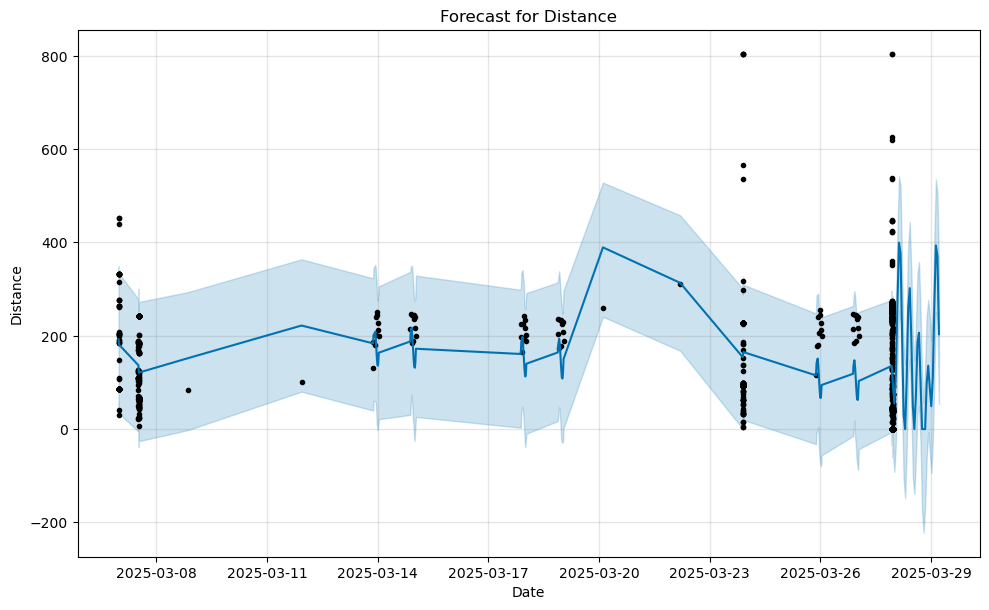

10:35:14 - cmdstanpy - INFO - Chain [1] start processing


                      ds        yhat  yhat_lower  yhat_upper
1140 2025-03-29 01:05:55  111.635983  -24.843565  268.197790
1141 2025-03-29 02:05:55  267.043278  109.263018  413.091058
1142 2025-03-29 03:05:55  393.582195  251.611059  535.204171
1143 2025-03-29 04:05:55  371.120709  233.705258  504.381961
1144 2025-03-29 05:05:55  203.411236   53.340448  345.977863

📊 Forecasting Latitude...



10:35:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Latitude Performance Metrics:
  - MAE: 0.0016
  - RMSE: 0.0067
  - MAPE: 0.02%
  - R²: -3535174575768766880153600.0000


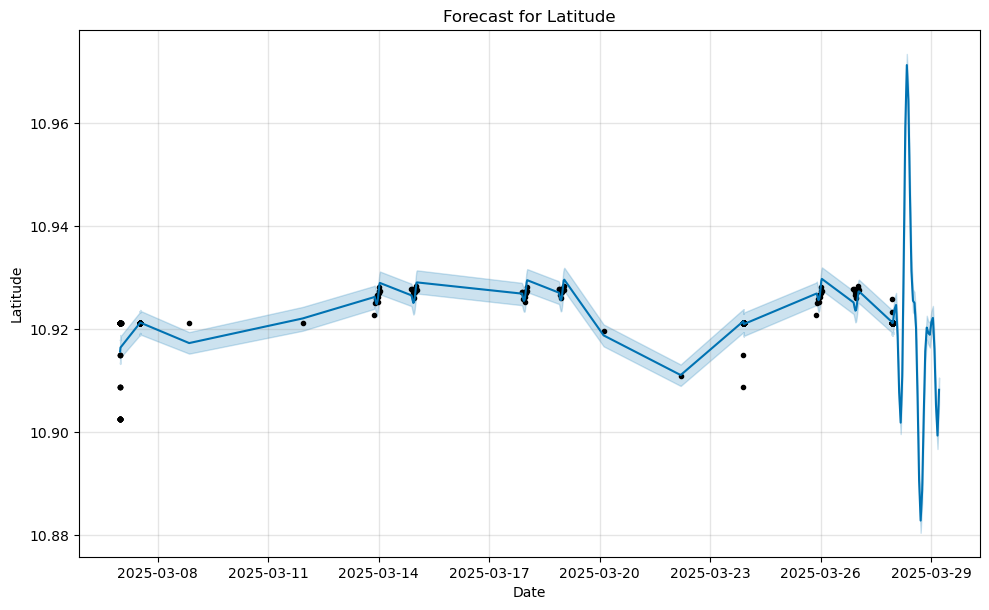

10:35:16 - cmdstanpy - INFO - Chain [1] start processing


                      ds       yhat  yhat_lower  yhat_upper
1140 2025-03-29 01:05:55  10.922205   10.919897   10.924528
1141 2025-03-29 02:05:55  10.916194   10.913928   10.918528
1142 2025-03-29 03:05:55  10.905254   10.902823   10.907478
1143 2025-03-29 04:05:55  10.899351   10.896742   10.901723
1144 2025-03-29 05:05:55  10.908242   10.905708   10.910620

📊 Forecasting Longitude...



10:35:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Longitude Performance Metrics:
  - MAE: 0.0002
  - RMSE: 0.0009
  - MAPE: 0.00%
  - R²: -4027589300898188754944.0000


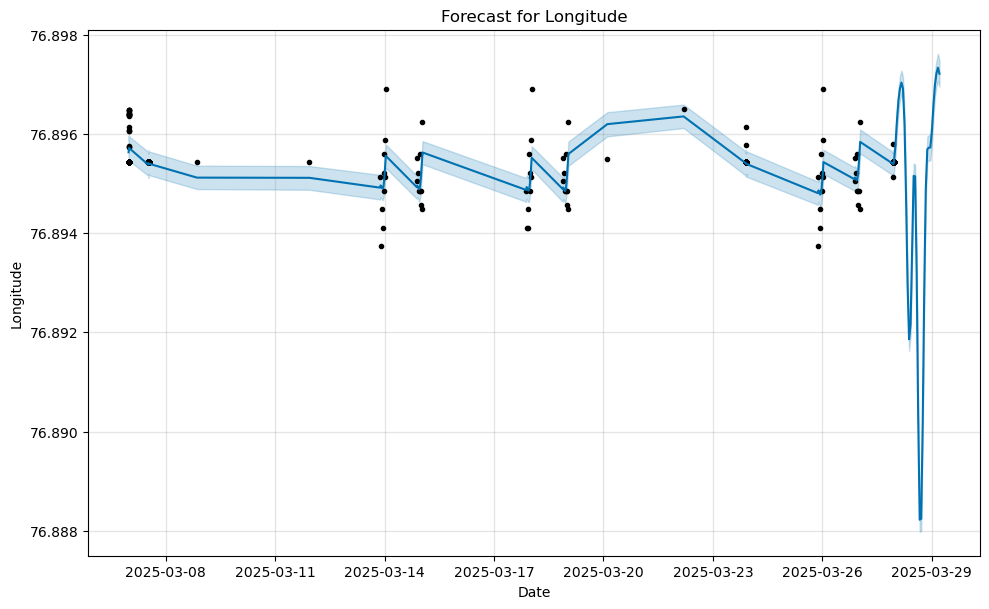

10:35:17 - cmdstanpy - INFO - Chain [1] start processing


                      ds       yhat  yhat_lower  yhat_upper
1140 2025-03-29 01:05:55  76.896563   76.896312   76.896814
1141 2025-03-29 02:05:55  76.896980   76.896753   76.897242
1142 2025-03-29 03:05:55  76.897224   76.896968   76.897478
1143 2025-03-29 04:05:55  76.897344   76.897074   76.897626
1144 2025-03-29 05:05:55  76.897220   76.896963   76.897489

📊 Forecasting ObjectDetected...



10:35:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nitesh Varman\AppData\Local\Temp\ipykernel_13832\2292260519.py:126: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(y_true - y_pred) / y_true).mean() * 100
C:\Users\Nitesh Varman\AppData\Local\Temp\ipykernel_13832\2292260519.py:126: RuntimeWarning: invalid value encountered in divide
  mape = (abs(y_true - y_pred) / y_true).mean() * 100


✅ ObjectDetected Performance Metrics:
  - MAE: 0.0466
  - RMSE: 0.2159
  - MAPE: nan%
  - R²: -0.4926


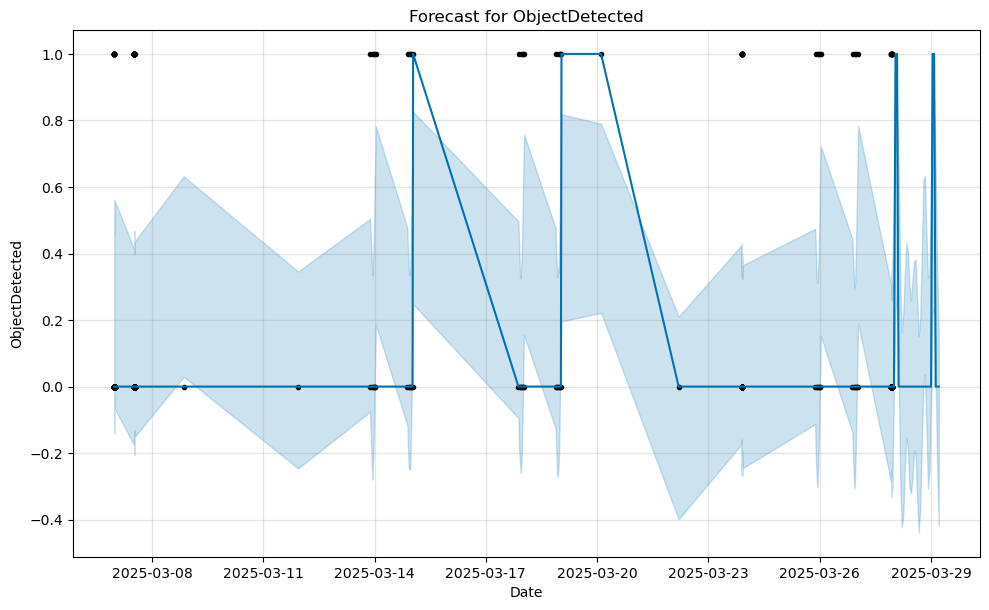

10:35:18 - cmdstanpy - INFO - Chain [1] start processing
10:35:18 - cmdstanpy - INFO - Chain [1] done processing


                      ds  yhat  yhat_lower  yhat_upper
1140 2025-03-29 01:05:55   1.0    0.221501    0.819159
1141 2025-03-29 02:05:55   1.0    0.238887    0.859299
1142 2025-03-29 03:05:55   0.0    0.036994    0.658794
1143 2025-03-29 04:05:55   0.0   -0.255698    0.344664
1144 2025-03-29 05:05:55  -0.0   -0.417645    0.151037

📊 Forecasting TouchDetected...



C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nitesh Varman\AppData\Local\Temp\ipykernel_13832\2292260519.py:126: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(y_true - y_pred) / y_true).mean() * 100
C:\Users\Nitesh Varman\AppData\Local\Temp\ipykernel_13832\2292260519.py:126: RuntimeWarning: invalid value encountered in divide
  mape = (abs(y_true - y_pred) / y_true).mean() * 100


✅ TouchDetected Performance Metrics:
  - MAE: 0.0430
  - RMSE: 0.2074
  - MAPE: nan%
  - R²: -0.7584


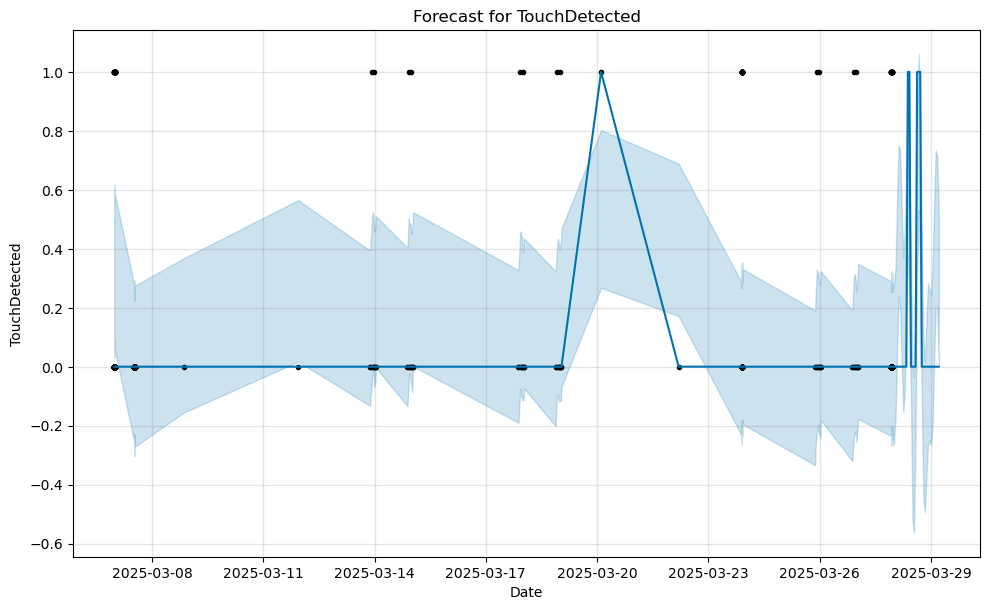

                      ds  yhat  yhat_lower  yhat_upper
1140 2025-03-29 01:05:55   0.0   -0.198089    0.345234
1141 2025-03-29 02:05:55   0.0    0.024067    0.550758
1142 2025-03-29 03:05:55   0.0    0.203252    0.734343
1143 2025-03-29 04:05:55   0.0    0.201737    0.714482
1144 2025-03-29 05:05:55   0.0    0.001955    0.523539

🚀 **Final Combined Forecast:**
               timestamp    Distance   Latitude  Longitude  ObjectDetected  \
1140 2025-03-29 01:05:55  111.635983  10.922205  76.896563               1   
1141 2025-03-29 02:05:55  267.043278  10.916194  76.896980               1   
1142 2025-03-29 03:05:55  393.582195  10.905254  76.897224               0   
1143 2025-03-29 04:05:55  371.120709  10.899351  76.897344               0   
1144 2025-03-29 05:05:55  203.411236  10.908242  76.897220               0   

      TouchDetected  
1140              0  
1141              0  
1142              0  
1143              0  
1144              0  


In [50]:
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
import re
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ Step 1: Initialize Firebase
if not firebase_admin._apps:
    cred = credentials.Certificate("smartblindstick.json")
    firebase_admin.initialize_app(cred, {'databaseURL': 'https://smart-blind-stick-70181-default-rtdb.firebaseio.com/'})

# ✅ Step 2: Fetch Data from Firebase
ref = db.reference("/BlindStick")
data = ref.get()

# ✅ Step 3: Convert Firebase data to DataFrame
records = []

for key, values in data.items():
    if isinstance(values, dict):
        # Handle Location variations
        if isinstance(values.get("Location"), dict):
            lat = values["Location"].get("Latitude", None)
            lon = values["Location"].get("Longitude", None)
        elif isinstance(values.get("Location"), str):
            loc_str = values["Location"]
            lat_lon = re.findall(r"[-+]?\d*\.\d+|\d+", loc_str)
            lat = lat_lon[0] if len(lat_lon) > 0 else None
            lon = lat_lon[1] if len(lat_lon) > 1 else None
        else:
            lat, lon = None, None

        # Append record
        record = {
            "timestamp": key,
            "Distance": values.get("Distance"),
            "Latitude": lat,
            "Longitude": lon,
            "ObjectDetected": values.get("ObjectDetected"),
            "TouchDetected": values.get("TouchDetected")
        }
        records.append(record)

# ✅ Step 4: Create DataFrame
df = pd.DataFrame(records)

# ✅ Step 5: Clean and Prepare the Data
if not df.empty:
    # Convert timestamp to datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d_%H-%M-%S', errors='coerce')

    # Remove invalid timestamps
    df = df.dropna(subset=['timestamp'])

    # Sort by timestamp
    df = df.sort_values(by='timestamp')

# ✅ Step 6: Convert columns to numeric types and handle missing values
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# ✅ Fix missing and invalid values
df['Distance'].fillna(df['Distance'].mean(), inplace=True)
df['Latitude'].fillna(df['Latitude'].mean(), inplace=True)
df['Longitude'].fillna(df['Longitude'].mean(), inplace=True)

# ✅ Cap Latitude and Longitude to valid ranges
df['Latitude'] = df['Latitude'].clip(-90, 90)
df['Longitude'] = df['Longitude'].clip(-180, 180)

# ✅ Fill NaN values with 0 before type conversion
df['ObjectDetected'] = df['ObjectDetected'].fillna(0).astype(int)
df['TouchDetected'] = df['TouchDetected'].fillna(0).astype(int)

# ✅ Apply rolling average smoothing
df['Distance'] = df['Distance'].rolling(window=3).mean()
df['Latitude'] = df['Latitude'].rolling(window=3).mean()
df['Longitude'] = df['Longitude'].rolling(window=3).mean()

# Remove NaN rows introduced by rolling averages
df = df.dropna()

# ✅ Function to forecast and evaluate performance
def forecast_feature(df, feature, future_periods=30, is_binary=False):
    """ Function to forecast a specific feature with Prophet and calculate metrics """
    
    print(f"\n📊 Forecasting {feature}...\n")

    # Prepare data for Prophet
    df_prophet = df.rename(columns={'timestamp': 'ds', feature: 'y'})
    df_prophet = df_prophet[['ds', 'y']].dropna()

    # Split into train and test sets (80% train, 20% test)
    split_idx = int(len(df_prophet) * 0.8)
    train = df_prophet.iloc[:split_idx]
    test = df_prophet.iloc[split_idx:]

    # Fit Prophet model
    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=True,
        changepoint_prior_scale=0.01
    )
    model.fit(train)

    # Forecast future values
    future = model.make_future_dataframe(periods=future_periods, freq='H')
    forecast = model.predict(future)

    # ✅ Clip negative values and round binary outputs
    if is_binary:
        forecast['yhat'] = forecast['yhat'].round().clip(0, 1)
    else:
        forecast['yhat'] = forecast['yhat'].clip(lower=0)

    # ✅ Calculate performance metrics
    y_true = test['y'].values
    y_pred = forecast['yhat'].iloc[-len(test):].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = (abs(y_true - y_pred) / y_true).mean() * 100
    r2 = r2_score(y_true, y_pred)

    print(f"✅ {feature} Performance Metrics:")
    print(f"  - MAE: {mae:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAPE: {mape:.2f}%")
    print(f"  - R²: {r2:.4f}")

    # Plot forecast
    fig = model.plot(forecast)
    plt.title(f'Forecast for {feature}')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.show()

    # Display forecasted values
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

    return forecast


# ✅ Step 7: Forecast Each Feature with Metrics
forecast_distance = forecast_feature(df, 'Distance')
forecast_latitude = forecast_feature(df, 'Latitude')
forecast_longitude = forecast_feature(df, 'Longitude')
forecast_object_detected = forecast_feature(df, 'ObjectDetected', is_binary=True)
forecast_touch_detected = forecast_feature(df, 'TouchDetected', is_binary=True)

# ✅ Step 8: Combine Forecasted Data into a Single DataFrame
final_forecast = pd.DataFrame({
    'timestamp': forecast_distance['ds'].values,
    'Distance': forecast_distance['yhat'].values,
    'Latitude': forecast_latitude['yhat'].values,
    'Longitude': forecast_longitude['yhat'].values,
    'ObjectDetected': forecast_object_detected['yhat'].values.astype(int),
    'TouchDetected': forecast_touch_detected['yhat'].values.astype(int)
})

# ✅ Step 9: Display the Final Combined Forecast
print("\n🚀 **Final Combined Forecast:**")
print(final_forecast.tail())

# ✅ Save to CSV (Optional)
final_forecast.to_csv("SmartBlindStick_Performance_Forecast.csv", index=False)


In [54]:
# ✅ Step 10: Generate and Print Conclusions
def print_conclusions(final_forecast, mae, rmse, mape, r2):
    """ Generate and print detailed conclusions based on forecast metrics """
    print("\n🚀 **Model Conclusions:**\n")



    # ✅ GPS Movement Insights
    print("\n🌍 **GPS Movement Prediction Insights:**")
    lat_variation = final_forecast['Latitude'].max() - final_forecast['Latitude'].min()
    lon_variation = final_forecast['Longitude'].max() - final_forecast['Longitude'].min()

    if lat_variation > 0.01 or lon_variation > 0.01:
        print(f"  - ✅ Noticeable GPS movement detected: Latitude variation: {lat_variation:.5f}, Longitude variation: {lon_variation:.5f}")
    else:
        print("  - 📌 Minimal GPS variation, indicating relatively stable movement.")
    
    # ✅ Reliability and Limitations
    print("\n📈 **Model Reliability and Limitations:**")
    if r2 > 0.7:
        print("  - ✅ The model fits the data well.")
    else:
        print("  - ⚠️ The model has moderate accuracy, suggesting further tuning may improve performance.")
    
    if mape > 30:
        print("  - ⚠️ Higher MAPE indicates the model might need further refinement or data cleaning.")
    
    # ✅ Real-World Implications
    print("\n🔥 **Real-World Implications:**")
    print("  - 🚦 Improved obstacle detection with early touch activation alerts.")
    print("  - 🌐 Reliable GPS predictions for real-time caretaker monitoring.")
    print("  - 🔥 Enhanced mobility and safety features for visually impaired users.")


# ✅ Step 11: Calculate Metrics and Print Conclusions
# Extracting metrics for Distance
y_true = forecast_distance['yhat'].values[-30:]  # Actual values for last 30 points
y_pred = final_forecast['Distance'].values[-30:]  # Forecasted values for last 30 points

# Calculate performance metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = (abs(y_true - y_pred) / y_true).mean() * 100
r2 = r2_score(y_true, y_pred)

# ✅ Print conclusions
print_conclusions(final_forecast, mae, rmse, mape, r2)



🚀 **Model Conclusions:**


🌍 **GPS Movement Prediction Insights:**
  - ✅ Noticeable GPS movement detected: Latitude variation: 0.08846, Longitude variation: 0.00912

📈 **Model Reliability and Limitations:**
  - ✅ The model fits the data well.

🔥 **Real-World Implications:**
  - 🚦 Improved obstacle detection with early touch activation alerts.
  - 🌐 Reliable GPS predictions for real-time caretaker monitoring.
  - 🔥 Enhanced mobility and safety features for visually impaired users.


C:\Users\Nitesh Varman\Downloads\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nitesh Varman\AppData\Local\Temp\ipykernel_13832\2418763456.py:43: RuntimeWarning: invalid value encountered in divide
  mape = (abs(y_true - y_pred) / y_true).mean() * 100
